# Part I: Ligand Activity Inference

**Requirements:**
|  | Description |
|-----------|-------------|
| **Python library** | simba (v1.2.0) |
| **Database** | NicheNet regulatory potential database, NicheNet ligand-receptor pair information |
| **Input data** | All genes list from your dataset + AnnData object of receiver cell type with sub-cell type annotation |

## [1] Import modules and set global environment

In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import colorcet as cc

import pulso
import simba as si
from itertools import combinations
from tqdm import tqdm
from joblib import Parallel, delayed

In [3]:
work_dir = "/home/qbe2n/PULSO"

In [4]:
prev_file = "/home/qbe2n/04.PSO/3.T&ILC/pp-1.h5ad"
adata = sc.read(prev_file)
adata

AnnData object with n_obs × n_vars = 14645 × 18985
    obs: 'suffix', 'sample', 'donor', 'condition', 'origin', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'S_score', 'G2M_score', 'phase', 'leiden_all_raw', 'scrub_doublet_score', 'scrub_predicted_doublet', 'dd_doublet_score', 'dd_predicted_doublet', 'doublet', 'leiden_all', 'celltype_0', 'celltype_0_numbered'
    var: 'gene_ids', 'feature_types', 'genome', 'entrezgene', 'map_location', 'type_of_gene', 'mt', 'rb', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'means', 'variances', 'highly_variable_nbatches', 'highly_variable_rank', 'variances_norm', 'highly_variable'
    uns: 'leiden_all', 'leiden_all_raw', 'leiden_all_raw_colors', 'log1

In [5]:
all_genes = pd.read_csv("/home/qbe2n/04.PSO/2.all/all_genes.csv", index_col=0)
all_genes

,gene_ids,feature_types,genome,entrezgene,map_location,type_of_gene,mt,rb,hb,n_cells_by_counts,...,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,means,variances,highly_variable_nbatches,highly_variable_rank,variances_norm,highly_variable
index,,,,,,,,,,,,,,,,,,,,,
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,no_annot,no_annot,no_annot,False,False,False,173,...,0.002641,99.738540,175,5.170484,0.002645,0.002729,0.0,NaN,0.924556,False
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,no_annot,no_annot,no_annot,False,False,False,82,...,0.001254,99.876071,83,4.430817,0.001254,0.001283,0.0,NaN,0.898573,False
LINC01409,ENSG00000237491,Gene Expression,GRCh38,105378580,1p36.33,ncRNA,False,False,False,1156,...,0.018018,98.252906,1203,7.093405,0.018181,0.019393,0.0,NaN,0.805390,False
FAM87B,ENSG00000177757,Gene Expression,GRCh38,400728,1p36.33,ncRNA,False,False,False,285,...,0.004779,99.569272,317,5.762051,0.004791,0.006279,1.0,1774.0,1.055910,False
LINC01128,ENSG00000228794,Gene Expression,GRCh38,643837,1p36.33,ncRNA,False,False,False,9078,...,0.174553,86.280170,12619,9.443038,0.190714,0.354871,0.0,NaN,1.039550,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,124905564,no_annot,protein-coding,False,False,False,1258,...,0.019575,98.098750,1308,7.177019,0.019768,0.021070,0.0,NaN,0.800486,False
AC004556.3,ENSG00000276345,Gene Expression,GRCh38,no_annot,no_annot,no_annot,False,False,False,3446,...,0.059366,94.791966,4047,8.305978,0.061163,0.079489,0.0,NaN,0.856274,False
AC136616.1,ENSG00000273554,Gene Expression,GRCh38,no_annot,no_annot,no_annot,False,False,False,30,...,0.000484,99.954660,32,3.496508,NaN,NaN,NaN,NaN,NaN,False


In [6]:
nn_tt_rel_file = "/home/qbe2n/04.PSO/resources/nichenet/nichenet_target_ligand.csv"
nn_tt_rel = pd.read_csv(
    nn_tt_rel_file, index_col=0, float_precision="round_trip"
).transpose()

og_shape = nn_tt_rel.shape
nn_tt_rel = nn_tt_rel.loc[
    nn_tt_rel.index.isin(all_genes.index), nn_tt_rel.columns.isin(adata.var_names)
].copy()
nn_tt_rel = nn_tt_rel.loc[
    (nn_tt_rel.sum(axis=1) > 0.0), (nn_tt_rel.sum(axis=0) > 0.0)
].copy()
print(f"{og_shape} > {nn_tt_rel.shape}")

og_shape = adata.shape
val_genes = pulso.get_sample_reproducible_genes(adata, n_cells_per_sample=10)
_adata = adata[:, val_genes].copy()
_adata = _adata[:, _adata.var_names.isin(nn_tt_rel.columns)]
print(f"{og_shape} > {_adata.shape}")

(1226, 33354) > (1086, 15524)
(14645, 18985) > (14645, 11372)


## [2] Cell-Gene co-embedding

In [7]:
simba_wd = "/home/qbe2n/PULSO/co-emb"
simba_id = "d5_batch"
simba_dir = f"{simba_wd}/pbg/{simba_id}"
simba_graph_file = f"{simba_dir}/pbg_graph.txt"
simba_model_dir = f"{simba_dir}/model"
si.settings.set_workdir(simba_wd)

Saving results in: /home/qbe2n/PULSO/co-emb


In [8]:
batch_key = "sample"
batch_cats = list(_adata.obs[batch_key].cat.categories)[::-1]

adatas_cg = []
for b in batch_cats:
    cur_adata = _adata[_adata.obs[batch_key] == b].copy()
    si.tl.discretize(cur_adata)
    adatas_cg.append(cur_adata)

adatas_cc = []
for pairs in combinations(_adata.obs[batch_key].unique(), 2):
    adatas_cc.append(
        si.tl.infer_edges(
            _adata[_adata.obs[batch_key] == pairs[0]].copy(),
            _adata[_adata.obs[batch_key] == pairs[1]].copy(),
            feature="highly_variable",
            n_components=30,
            k=1,
            metric="euclidean",
        )
    )

si.tl.gen_graph(
    list_CG=adatas_cg,
    list_CC=adatas_cc,
    use_highly_variable=False,
    dirname=simba_dir,
)

#shared features: 1105
Performing randomized SVD ...
Searching for mutual nearest neighbors ...
455 edges are selected
#shared features: 1105
Performing randomized SVD ...
Searching for mutual nearest neighbors ...
355 edges are selected
#shared features: 1105
Performing randomized SVD ...
Searching for mutual nearest neighbors ...
336 edges are selected
#shared features: 1105
Performing randomized SVD ...
Searching for mutual nearest neighbors ...
319 edges are selected
#shared features: 1105
Performing randomized SVD ...
Searching for mutual nearest neighbors ...
412 edges are selected
#shared features: 1105
Performing randomized SVD ...
Searching for mutual nearest neighbors ...
439 edges are selected
#shared features: 1105
Performing randomized SVD ...
Searching for mutual nearest neighbors ...
437 edges are selected
#shared features: 1105
Performing randomized SVD ...
Searching for mutual nearest neighbors ...
344 edges are selected
#shared features: 1105
Performing randomized SVD

In [9]:
si.load_graph_stats(simba_dir)

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.001819
Weight decay being used for training is 0.001819
Converting input data ...
[2026-02-08 15:21:04.633063] Using the 200 relation types given in the config
[2026-02-08 15:21:04.634041] Searching for the entities in the edge files...
[2026-02-08 15:21:17.516083] Entity type C:
[2026-02-08 15:21:17.516580] - Found 1082 entities
[2026-02-08 15:21:17.516867] - Removing the ones with fewer than 1 occurrences...
[2026-02-08 15:21:17.517231] - Left with 1082 entities
[2026-02-08 15:21:17.517481] - Shuffling them...
[2026-02-08 15:21:17.518005] Entity type C2:
[2026-02-08 15:21:17.518238] - Found 1213 entities
[2026-02-08 15:21:17.518474] - Removing the ones with fewer than 1 occurrences...
[2026-02-08 15:21:17.519275] - Left with 1213 entities
[2026-02-08 15:21:17.519475] - Shuffling them...
[2026-02-08 15:21:17.520003] Entity type C3:
[2026-02-08 15:21:17.520263] - Found 679 entities
[2026-02-08 15:21:17.

/data/conda-users/envs/qbe2n/pso-sc-gpu-250514/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:


[2026-02-08 15:22:09.345414] - Processed 19484872 edges in total
Starting training ...


/data/conda-users/envs/qbe2n/pso-sc-gpu-250514/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/data/conda-users/envs/qbe2n/pso-sc-gpu-250514/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/data/conda-users/envs/qbe2n/pso-sc-gpu-250514/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:

Finished


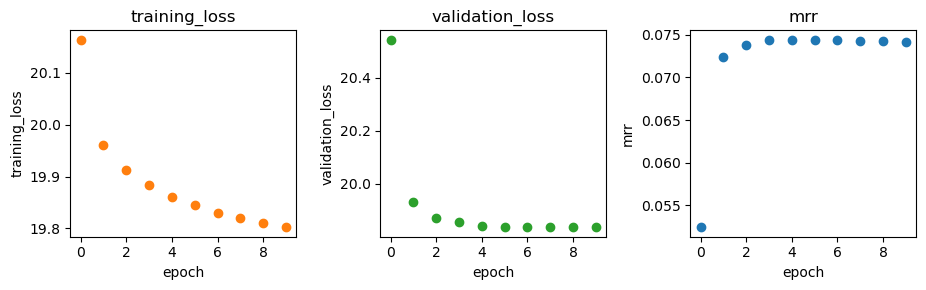

In [10]:
dict_config = si.settings.pbg_params.copy()
dict_config["wd_interval"] = 10
dict_config["workers"] = 32

si.tl.pbg_train(
    auto_wd=True,
    save_wd=True,
    pbg_params=dict_config,
    dirname=simba_dir,
)
si.pl.pbg_metrics(fig_ncol=3, fig_size=(3, 3))

In [11]:
si.load_pbg_config(simba_model_dir)

In [12]:
adata_c = pulso.cell_cell_emb(_adata=_adata, dict_adata=si.read_embedding(), out_file=f"{work_dir}/simba_cc.h5ad")
print(adata_c)

Creating /home/qbe2n/PULSO/simba_cc.h5ad...
Writing /home/qbe2n/PULSO/simba_cc.h5ad...
AnnData object with n_obs × n_vars = 14645 × 50
    obs: 'suffix', 'sample', 'donor', 'condition', 'origin', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'S_score', 'G2M_score', 'phase', 'leiden_all_raw', 'scrub_doublet_score', 'scrub_predicted_doublet', 'dd_doublet_score', 'dd_predicted_doublet', 'doublet', 'leiden_all', 'celltype_0', 'celltype_0_numbered'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'


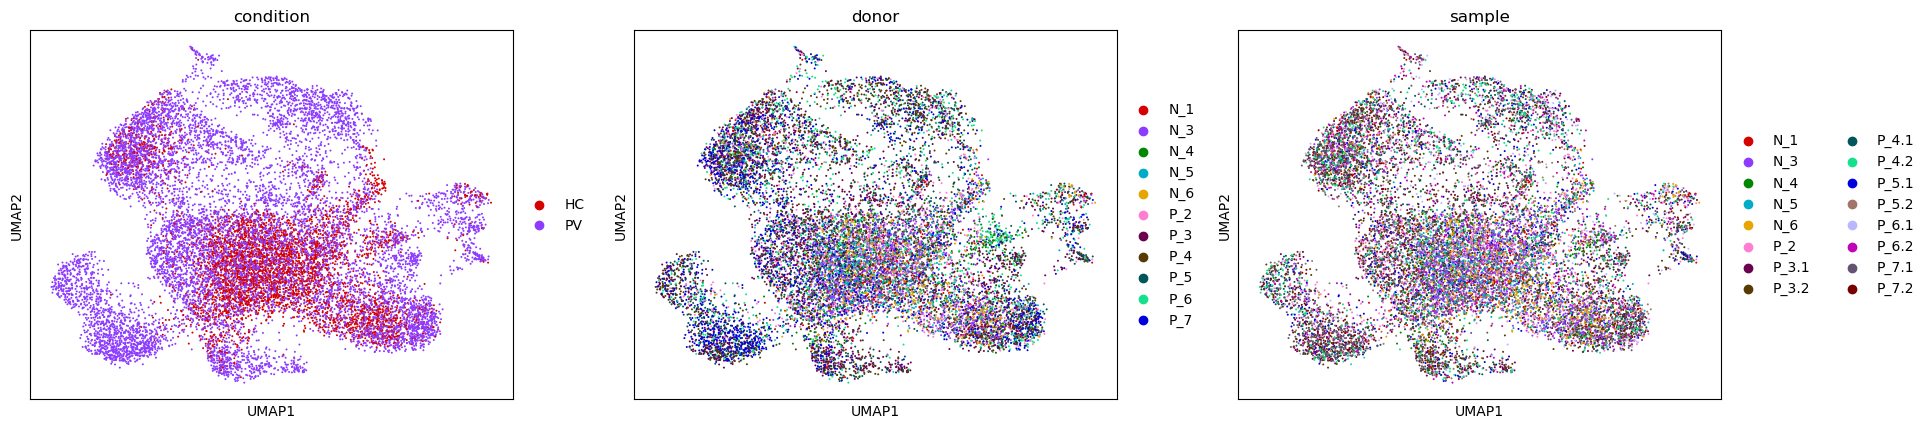

In [13]:
sc.pl.umap(
    adata_c,
    color=["condition", "donor", "sample"],
    palette=cc.glasbey_dark,
)

In [14]:
adata_cg = pulso.cell_gene_emb(_adata=_adata, dict_adata=si.read_embedding(), adata_c=adata_c, out_file=f"{work_dir}/simba_cg.h5ad", cat_order=["PV", "HC", "gene"])
print(adata_cg)

Creating /home/qbe2n/PULSO/simba_cg.h5ad...
Performing softmax transformation for query data 0;


Writing /home/qbe2n/PULSO/simba_cg.h5ad...
AnnData object with n_obs × n_vars = 26017 × 50
    obs: 'id_dataset', 'entity_anno', 'condition'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'


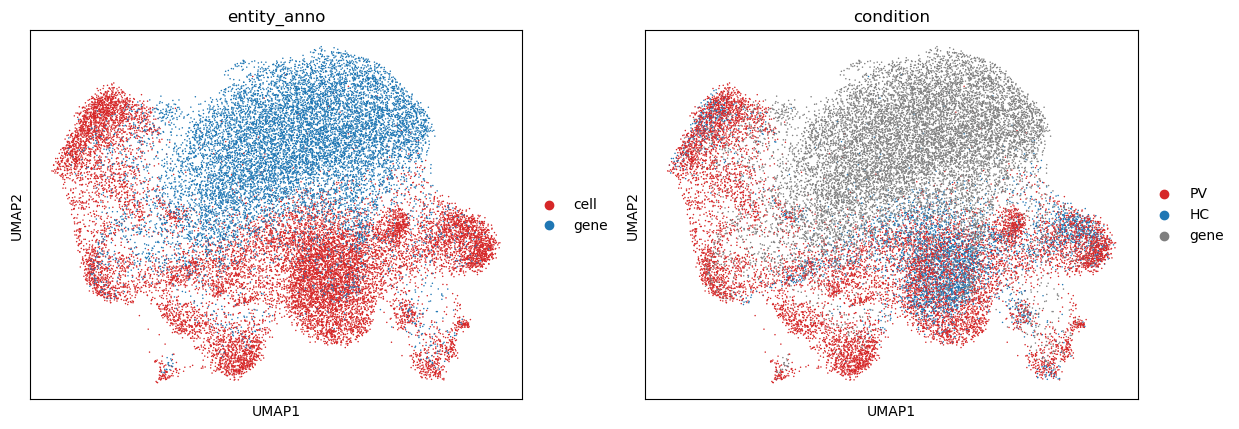

In [15]:
sc.pl.umap(
    adata_cg,
    color=["entity_anno", "condition"],
    color_map=cc.cm.CET_D1A,
    vcenter=0.0,
    palette=["tab:red", "tab:blue", "tab:gray"],
)

In [16]:
cg_dist = pulso.cg_dist(adata_cg, f"{work_dir}/simba_cg_dist.pq")
cg_dist

,HADHA,DDX24,PWP1,TSHZ2,TXN,MYEF2,STIL,FKBP14,BACH1,TFAM,...,BISPR,ATP1B3,MSRB1,CHST11,FLVCR1,WDFY1,EIF3M,DMPK,MTOR,PABPC1
TGCCCTAAGGCTCAGA-16,1.167656,1.215010,1.173958,1.311305,1.124212,1.182420,1.146413,1.216825,1.399403,1.199871,...,1.102702,1.212839,1.109865,1.140157,1.166898,1.200931,1.161139,1.151362,1.293135,1.239399
TGCGTGGGTGGAAAGA-16,1.702218,1.696170,1.710075,1.851181,1.714101,1.667312,1.375060,1.675995,1.818176,1.704275,...,1.624167,1.672607,1.701373,1.656504,1.645469,1.702517,1.701818,1.588983,1.704339,1.776501
GGAGCAAGTACCTACA-16,1.352173,1.434792,1.335353,1.561266,1.424578,1.328164,1.431799,1.373227,1.553618,1.352512,...,1.311177,1.468517,1.334546,1.361093,1.317237,1.302089,1.382134,1.348325,1.354506,1.442668
ATTGGACAGTTCGATC-16,1.185329,1.250031,1.189985,1.268575,1.274022,1.197069,1.296077,1.206040,1.378983,1.188071,...,1.207829,1.320450,1.223943,1.220592,1.190347,1.181916,1.196160,1.201609,1.174070,1.187173
CACCAGGCAGATCGGA-16,1.194746,1.280295,1.233123,1.184265,1.271367,1.266511,1.330526,1.256586,1.203474,1.237010,...,1.192177,1.354862,1.187572,1.267147,1.242459,1.233027,1.261083,1.211171,1.269968,1.341203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTAGTGACATATACGC-10,1.508215,1.383661,1.499404,1.430633,1.448500,1.502954,1.602259,1.447185,1.234511,1.474201,...,1.550345,1.376078,1.503683,1.514462,1.514006,1.523065,1.507058,1.506235,1.494105,1.531859
GGCGACTTCAGCGATT-10,1.076200,1.041653,1.015464,1.136570,1.060271,1.046611,1.255298,1.037946,1.162236,1.012870,...,1.125411,1.061521,1.102546,1.039303,1.046512,1.042067,1.054606,1.105460,1.014244,1.004915
TACTCATCAAGGTGTG-10,1.118075,1.067718,1.097445,1.288692,1.084996,1.078686,1.164510,1.079896,1.316130,1.080889,...,1.117294,1.033003,1.113789,1.076306,1.078259,1.074617,1.092450,1.109235,1.150906,1.056215
CTTACCGCAAACTGCT-10,1.555024,1.483883,1.564520,1.635158,1.487833,1.532489,1.214107,1.511630,1.662600,1.556628,...,1.499167,1.434556,1.559332,1.476880,1.501840,1.583605,1.509771,1.448297,1.586629,1.548890


## [3] Single-cell Ligand Prediction for sub cell type

In [17]:
lig_rec_dict = pulso.ligand_receptor("/home/qbe2n/04.PSO/resources/nichenet/nichenet_ligand_receptor.csv")

In [18]:
lig_target_rel_df = pulso.ligand_target("/home/qbe2n/04.PSO/resources/nichenet/nichenet_target_ligand.csv", all_genes, adata.var_names)
lig_target_rel_df

(1226, 33354) > (1086, 15524)


,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
A2M,0.001850,0.000740,0.008469,0.000189,0.002068,0.003306,0.004532,0.002453,0.004164,0.004106,...,0.002974,0.003923,0.004776,0.001248,0.002518,0.002194,0.002756,0.002610,0.004213,0.003451
AANAT,0.001111,0.000468,0.004069,0.000150,0.001327,0.001967,0.002906,0.001529,0.002283,0.002260,...,0.001775,0.002187,0.002896,0.000762,0.001514,0.001895,0.001752,0.001743,0.002475,0.002206
ABCA1,0.001423,0.000519,0.006426,0.000149,0.002203,0.002729,0.004169,0.002498,0.003330,0.003660,...,0.002719,0.003615,0.004357,0.001272,0.001771,0.002299,0.002926,0.002380,0.004070,0.003380
ACE,0.002859,0.000784,0.010519,0.000160,0.002433,0.003723,0.006948,0.003945,0.006352,0.005932,...,0.004860,0.005662,0.008923,0.001272,0.004559,0.003088,0.004804,0.003167,0.008413,0.006834
ACE2,0.001139,0.000375,0.005719,0.000114,0.001143,0.002826,0.002837,0.001538,0.002441,0.002526,...,0.001791,0.002336,0.003206,0.000818,0.001476,0.001329,0.001714,0.001662,0.002530,0.002196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XCL2,0.000943,0.000292,0.004636,0.000120,0.001247,0.001751,0.002748,0.001476,0.002388,0.002323,...,0.001765,0.002142,0.002989,0.000712,0.001323,0.001193,0.001445,0.001527,0.002398,0.001928
ZDHHC5,0.001520,0.001884,0.005476,0.000180,0.002190,0.003683,0.004406,0.002043,0.003484,0.003298,...,0.002566,0.003452,0.003818,0.001388,0.002760,0.002819,0.002424,0.003468,0.003842,0.003762
ZG16B,0.001226,0.000408,0.005606,0.000159,0.001790,0.002424,0.003749,0.001832,0.003182,0.003181,...,0.002479,0.003289,0.003976,0.001044,0.001927,0.001779,0.002507,0.002398,0.003505,0.003041
ZNRF3,0.001021,0.000335,0.004587,0.000146,0.001310,0.002924,0.002798,0.001588,0.003592,0.002579,...,0.001977,0.002858,0.004392,0.001599,0.001516,0.001909,0.002704,0.002110,0.003892,0.002348


In [19]:
prev_file = f"{work_dir}/simba_cg_dist.pq"
out_file = f"{work_dir}/simba_cg_tzdist.pq"

cg_dist_df = pulso.dist_prep(prev_file, out_file)
cg_dist_df

,HADHA,DDX24,PWP1,TSHZ2,TXN,MYEF2,STIL,FKBP14,BACH1,TFAM,...,BISPR,ATP1B3,MSRB1,CHST11,FLVCR1,WDFY1,EIF3M,DMPK,MTOR,PABPC1
TGCCCTAAGGCTCAGA-16,0.355501,0.474054,0.366645,0.614055,0.171765,0.387388,-0.168586,0.508226,0.842131,0.443960,...,0.094917,0.368755,0.139021,0.242218,0.337559,0.455475,0.329391,0.249643,0.694170,0.478547
TGCGTGGGTGGAAAGA-16,1.731347,1.828946,1.770968,1.880270,1.775130,1.710745,0.787020,1.776613,1.971464,1.808497,...,1.578422,1.808789,1.716105,1.662484,1.674657,1.730185,1.742102,1.570308,1.795865,1.780543
GGAGCAAGTACCTACA-16,0.905352,1.158296,0.860023,1.272174,1.081110,0.844650,0.995758,0.994920,1.311883,0.920677,...,0.775881,1.236518,0.847165,0.918409,0.817258,0.761040,0.979203,0.905946,0.883917,1.017121
ATTGGACAGTTCGATC-16,0.412661,0.592281,0.419208,0.484905,0.655150,0.436304,0.479210,0.472017,0.773979,0.404092,...,0.456649,0.758346,0.520251,0.503057,0.416937,0.394424,0.440936,0.428888,0.292571,0.328628
CACCAGGCAGATCGGA-16,0.442695,0.691398,0.556536,0.212402,0.647144,0.658875,0.616063,0.638565,0.117070,0.566424,...,0.405333,0.874995,0.404026,0.645966,0.587050,0.555822,0.638610,0.462008,0.619661,0.756589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTAGTGACATATACGC-10,1.302692,1.010505,1.292632,0.947152,1.144165,1.320121,1.569424,1.203147,0.243549,1.256474,...,1.407621,0.945169,1.282908,1.323633,1.357258,1.335647,1.298198,1.355966,1.278967,1.234101
GGCGACTTCAGCGATT-10,0.041645,-0.175829,-0.204970,0.046641,-0.056829,-0.103511,0.311649,-0.146255,-0.058901,-0.250839,...,0.176603,-0.254990,0.112789,-0.113345,-0.101253,-0.096120,-0.033891,0.077726,-0.332431,-0.240545
TACTCATCAAGGTGTG-10,0.189274,-0.070417,0.103172,0.546411,0.033336,0.019002,-0.085192,0.018393,0.554158,0.018562,...,0.147641,-0.384442,0.152988,0.021127,0.019929,0.025153,0.099561,0.092178,0.208645,-0.072371
CTTACCGCAAACTGCT-10,1.412101,1.294555,1.448744,1.440548,1.245366,1.393955,0.135868,1.374768,1.602975,1.465493,...,1.283145,1.132089,1.412213,1.228426,1.326283,1.474995,1.304802,1.197537,1.516747,1.274357


In [20]:
gene_counts = pd.Series(adata.X.getnnz(axis=1))
abs_lower_bound = int(np.round(gene_counts.min() / 4))
print(abs_lower_bound)

97


In [21]:
out_file = f"{work_dir}/lig_pred.pq"
import utils
with utils.tqdm_joblib(tqdm(total=adata.shape[0], mininterval=1, miniters=5)) as _:
    res = Parallel(n_jobs=16)(
        delayed(pulso.get_lig_actv)(
            adata,
            i,
            cg_dist_df.loc[i, :].copy(deep=True),
            abs_lower_bound,
            lig_target_rel_df,
            lig_rec_dict,
        )
        for i in adata.obs_names.to_list()
    )
scores = pd.concat(res, axis=1, join="outer").transpose().fillna(0.0)
scores.to_parquet(out_file, compression=None, index=True)

scores

100%|██████████| 14645/14645 [04:24<00:00, 55.31it/s]


,ADAM10,AMELY,APP,BMP2,BMP3,BMP4,BMP5,BMP6,BMP7,BMP8A,...,ITGB1,IGFBP7,APLN,NPB,NPW,PPY,MST1,LIN7B,BPI,CD52
AAACCTGTCCACTGGG-1,0.060159,0.060450,0.063104,0.108736,0.021622,0.022515,0.024791,0.02336,0.018089,0.012569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGGGCAAGAGGCT-1,-0.019402,-0.017891,0.028915,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGGGCAATCACAC-1,0.029266,0.005267,-0.027911,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGATGCACACCGAC-1,0.088731,0.000000,0.029156,0.000000,0.000000,0.073018,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGCAAGTCGTCTTC-1,0.098775,0.114510,-0.004613,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCTGCCAT-16,-0.166835,-0.178379,-0.045930,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTCACACGTGAGA-16,-0.093050,-0.122594,-0.022205,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTCAGTAGCTAAA-16,0.105150,0.064109,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.047841,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTCAGTGTGTGCC-16,0.120557,0.000000,0.040453,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ldata = pulso.val_lig(scores)
ldata.write(f"{work_dir}/lig_pred.h5ad")
ldata

AnnData object with n_obs × n_vars = 14645 × 988